#Description:
In this notebook, we will explore LSTM models' accuracy in one-step-ahead (daily) weather forecast

#Part 1: Data Preparation

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/DeepLearning_2024"

Mounted at /content/drive
P1  P2	Project


In [ ]:
weather = pd.read_csv("/content/drive/MyDrive/DeepLearning_2024/Project/barcelona last10years.csv", on_bad_lines='skip')
weather = weather[['datetime', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'precip', 'precipprob' ,'preciptype', 'windspeed', 'winddir', 'cloudcover']]

In [ ]:
weather = weather.rename(columns={'temp': 'temperature', 'datetime': 'date'})
weather['date'] = pd.to_datetime(weather['date'])
weather.set_index('date')
weather.head(5)

,date,tempmax,tempmin,temperature,dew,humidity,precip,precipprob,preciptype,windspeed,winddir,cloudcover
0,2014-01-01,14.4,3.1,9.0,4.6,74.7,0.000,0,NaN,20.9,300.2,50.5
1,2014-01-02,17.3,7.7,11.8,8.6,81.5,0.000,0,NaN,12.1,288.0,33.1
2,2014-01-03,17.9,10.9,13.4,10.0,80.6,0.009,100,rain,18.9,312.9,41.1
3,2014-01-04,15.5,10.0,12.1,9.8,86.9,0.986,100,rain,26.5,267.5,46.1
4,2014-01-05,14.1,8.1,10.6,1.6,54.6,0.110,100,rain,29.2,295.5,41.7


Data description:

* date: YYYY-MM-DD

* temperature: average temperature in Istanbul at the given date, in degrees Celcius

* tempmax: maximum temperature in Istanbul at the given date, in degrees Celcius

* tempmin: minimum temperature in Istanbul at the given date, in degrees Celcius

* dew: dew point; required temperatuer to have dew in the air

* humidity: average humiditiy in Istanbul at the given date, as percentage

* precip: precipitation, in mm

* preciptype: type of precipitation, such as rain, snow

* windspeed: average windspeed in kilometers per hour

* winddir: direction of the wind, 360$^\circ$

* cloudcover: percentage of sky covered in cloud, daily average

Will be filling NA values of cloudcover with 0, NA values in precipitation type with None, and one-hot-encode precipitation type & month


In [ ]:
weather['preciptype'] =  weather['preciptype'].fillna('None')
weather['cloudcover'] =  weather['cloudcover'].fillna(0)
weather.isna().sum()

date           0
tempmax        0
tempmin        0
temperature    0
dew            0
humidity       0
precip         0
precipprob     0
preciptype     0
windspeed      0
winddir        0
cloudcover     0
dtype: int64

There are only a few other NA values, deleting these rows will result negligible data loss.

In [ ]:
weather.dropna(inplace=True)
weather.info

<bound method DataFrame.info of            date  tempmax  tempmin  temperature   dew  humidity  precip  \
0    2014-01-01     14.4      3.1          9.0   4.6      74.7   0.000   
1    2014-01-02     17.3      7.7         11.8   8.6      81.5   0.000   
2    2014-01-03     17.9     10.9         13.4  10.0      80.6   0.009   
3    2014-01-04     15.5     10.0         12.1   9.8      86.9   0.986   
4    2014-01-05     14.1      8.1         10.6   1.6      54.6   0.110   
...         ...      ...      ...          ...   ...       ...     ...   
3790 2024-05-22     19.7     15.8         18.0  13.3      74.0   0.695   
3791 2024-05-23     20.5     13.5         17.5  12.1      71.0   0.104   
3792 2024-05-24     20.4     14.9         17.8  11.8      68.3   0.200   
3793 2024-05-25     21.9     12.5         17.9  12.4      71.6   0.000   
3794 2024-05-26     23.4     14.0         19.2  14.6      75.7   0.000   

      precipprob preciptype  windspeed  winddir  cloudcover  
0              0       None       20.9    300.2        50.5  
1              0       None       12.1    288.0        33.1  
2            100       rain       18.9    312.9        41.1  
3            100       rain       26.5    267.5        46.1  
4            100       rain       29.2    295.5        41.7  
...          ...        ...        ...      ...         ...  
3790         100       rain       22.5    131.0        58.2  
3791         100       rain       19.7    104.4        36.4  
3792         100       rain       22.1     93.7        44.8  
3793           0       None       26.1    175.1        30.8  
3794           0       None       19.4    144.2        38.2  

[3795 rows x 12 columns]>

In [ ]:
weather['month'] = weather['date'].dt.month

In [ ]:
weather.head(2)

,date,tempmax,tempmin,temperature,dew,humidity,precip,precipprob,preciptype,windspeed,winddir,cloudcover,month
0,2014-01-01,14.4,3.1,9.0,4.6,74.7,0.0,0,None,20.9,300.2,50.5,1
1,2014-01-02,17.3,7.7,11.8,8.6,81.5,0.0,0,None,12.1,288.0,33.1,1


Our main dataframe will be "weather". Let's examine the data even more:

In [ ]:
weather_seperated = weather[['date', 'month', 'temperature']].copy(deep=True)
weather_seperated['year'] = weather['date'].dt.year
weather_seperated.drop(['date'], axis=1, inplace=True)
weather_seperated = weather_seperated.pivot_table(index='month',  columns='year', values='temperature')
weather_seperated.head(2)

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
month,,,,,,,,,,,
1,10.341935,8.996667,11.630000,7.616129,11.822581,7.596774,10.158065,9.154839,8.883871,8.700000,10.096774
2,10.878571,8.882143,11.624138,11.707143,8.085714,10.117857,12.893103,12.571429,11.450000,8.721429,12.034483


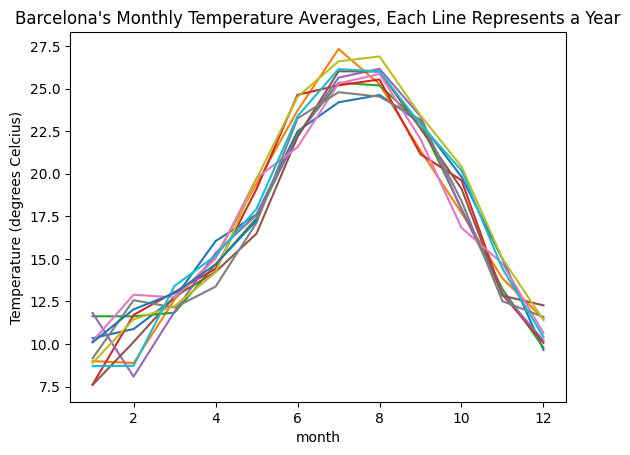

In [ ]:
weather_seperated.plot()
plt.ylabel('Temperature (degrees Celcius)')
plt.title("Barcelona's Monthly Temperature Averages, Each Line Represents a Year")
plt.legend().remove()
plt.show()

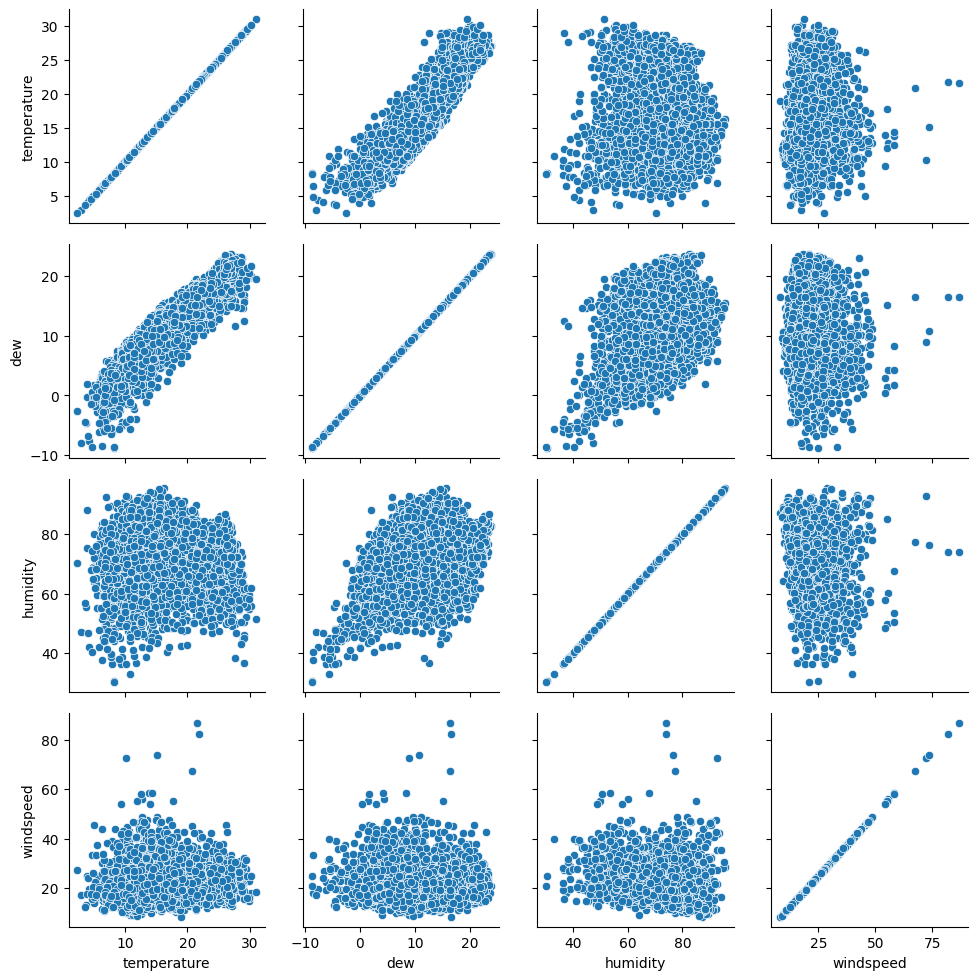

In [ ]:
g = sns.PairGrid(weather[['temperature', 'dew', 'humidity', 'windspeed']])
g.map(sns.scatterplot)

#Part 2: Checking the Naive prediction's error

A naive temperature prediction would be "tomorrow's average temperature will be the same with today". We will check the error term when we use this prediction and use it as the benchmark of our LSTM model.

In [ ]:
weather_naive = weather[['date', 'temperature']].copy(deep=True)
weather_naive['prev_temperature'] = weather_naive['temperature'].shift(1)
weather_naive.drop([0], inplace=True)
weather_naive['difference'] = weather_naive['temperature'] - weather_naive['prev_temperature']
weather_naive['square_error'] = weather_naive['difference'] ** 2
weather_naive.head(2)

,date,temperature,prev_temperature,difference,square_error
1,2014-01-02,11.8,9.0,2.8,7.84
2,2014-01-03,13.4,11.8,1.6,2.56


In [ ]:
square_error = weather_naive['square_error'].mean()
print(f'Square Error of the Naive Approach is {square_error:.3f}')

Square Error of the Naive Approach is 1.888


#Part 3: LSTM model for Weather Prediction

In [ ]:
weather.head(2)

,date,tempmax,tempmin,temperature,dew,humidity,precip,precipprob,preciptype,windspeed,winddir,cloudcover,month
0,2014-01-01,14.4,3.1,9.0,4.6,74.7,0.0,0,None,20.9,300.2,50.5,1
1,2014-01-02,17.3,7.7,11.8,8.6,81.5,0.0,0,None,12.1,288.0,33.1,1


In [ ]:
#One-hot-encoding precipitation type and month
weather_LSTM = weather.copy(deep=True)
weather_LSTM = pd.get_dummies(weather, columns = ['preciptype', 'month'])
weather_LSTM.columns

Index(['date', 'tempmax', 'tempmin', 'temperature', 'dew', 'humidity',
       'precip', 'precipprob', 'windspeed', 'winddir', 'cloudcover',
       'preciptype_None', 'preciptype_rain', 'preciptype_rain,snow', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [ ]:
weather_LSTM.head(2)

,date,tempmax,tempmin,temperature,dew,humidity,precip,precipprob,windspeed,winddir,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2014-01-01,14.4,3.1,9.0,4.6,74.7,0.0,0,20.9,300.2,...,False,False,False,False,False,False,False,False,False,False
1,2014-01-02,17.3,7.7,11.8,8.6,81.5,0.0,0,12.1,288.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
input_data = weather_LSTM.drop(['date'], axis=1)
targets = weather_LSTM['temperature'].values

We need to decide how many days' prior we need to see to predict today. Trial and error is a valid approach, but for this example I will be using 20 days as the target is not to get the best answer, just to check if LSTM is getting better predictions than the naive approach.

In [ ]:
T = 20                  #Number of timesteps to look while predicting (BY DEFAULT --> 20)
D = input_data.shape[1]   #Dimensionality of the input
N = len(input_data) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 20 × 25 × 3775


In [ ]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

We need to create the train set and the test set and convert from numpy to torch.

In [ ]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

In [ ]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

Creation of the validation and test set

In [ ]:
# N = len(input_data)
# T = 20 # longitud de la secuencia
# D = input_data.shape[1]  # número de características

# X = np.zeros((N - T, T, D))
# y = np.zeros((N - T, 1))

# for i in range(N - T):
#     X[i, :, :] = input_data[i:i+T]
#     y[i] = targets[i+T]

# X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42)  # 0.1111 * 0.9 ≈ 0.1

In [ ]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))
#X_val = torch.from_numpy(X_val.astype(np.float32))
#y_val = torch.from_numpy(y_val.astype(np.float32))

Using a classical LSTM structure

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 10,000 and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [ ]:
model = LSTM(D, 512, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(25, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

At training, Adam optimizer failed to converge for a long time (started to converge at around 800th epoch). SGD with 0.9 momentum worked well.

In [ ]:
# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=200):

  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()

    if (epoch + 1) % 50 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

  return train_losses, test_losses

Let's create another test function for when we split the test set into a validation set and a final test set, in this case we will use a 80/10/10 distribution

In [ ]:
# Testing after validation
def test(model,X_test,y_test):
    criterion = nn.MSELoss()
    test_outputs = model(X_test)
    test_losses = criterion(test_outputs, y_test)
    return test_losses

In [ ]:
# Training
def train_validate(model,
          learning_rate,
          X_train,
          y_train,
          X_val,
          y_val,
          X_test,
          y_test,
          epochs=200):

  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

  train_losses = np.zeros(epochs)
  validate_losses = np.zeros(epochs)

  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Training loss
    train_losses[epoch] = loss.item()

    validate_outputs = model(X_val)
    validate_loss = criterion(validate_outputs, y_val)
    validate_losses[epoch] = validate_loss.item()


    if (epoch + 1) % 50 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Validation Loss: {validate_loss.item():.3f}')

  test_losses = test(model,X_test,y_test)
  print(f"Test Loss: {test_losses:.3f}")

  return train_losses, validate_losses, test_losses

In [ ]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
#X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=750) # By default --> epochs = 750

At epoch 50 of 750, Train Loss: 2.727, Test Loss: 3.280
At epoch 100 of 750, Train Loss: 1.854, Test Loss: 2.409
At epoch 150 of 750, Train Loss: 1.653, Test Loss: 2.180
At epoch 200 of 750, Train Loss: 1.531, Test Loss: 2.113
At epoch 250 of 750, Train Loss: 1.453, Test Loss: 2.130
At epoch 300 of 750, Train Loss: 1.396, Test Loss: 2.142
At epoch 350 of 750, Train Loss: 1.350, Test Loss: 2.155
At epoch 400 of 750, Train Loss: 1.307, Test Loss: 2.171
At epoch 450 of 750, Train Loss: 1.265, Test Loss: 2.168
At epoch 500 of 750, Train Loss: 1.228, Test Loss: 2.179
At epoch 550 of 750, Train Loss: 1.185, Test Loss: 2.220
At epoch 600 of 750, Train Loss: 1.255, Test Loss: 2.603
At epoch 650 of 750, Train Loss: 1.109, Test Loss: 2.302
At epoch 700 of 750, Train Loss: 1.081, Test Loss: 2.322
At epoch 750 of 750, Train Loss: 1.036, Test Loss: 2.351


In [ ]:
# train_losses, validate_losses, test_losses = train_validate(model,
#                                     0.1,
#                                     X_train,
#                                     y_train,
#                                     X_val,
#                                     y_val,
#                                     X_test,
#                                     y_test,
#                                     epochs=750) # By default --> epochs = 750

That is to save the state of the model and the test and train losses arrays, to be able to analyze them in graphs if necessary

In [ ]:
#print(test_losses.item())

In [ ]:
#torch.save(model.state_dict(),"/content/drive/MyDrive/DeepLearning_2024/Project/Results/" + "model2.ckpt")

In [ ]:
#np.save("/content/drive/MyDrive/DeepLearning_2024/Project/Results/test_losses2", test_losses)
#np.save("/content/drive/MyDrive/DeepLearning_2024/Project/Results/train_losses2", train_losses)

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

We don't see an overfitting pattern. It's possible to train the model a little more as we haven't started to see the seperation of train loss - test loss in a meaningful manner, but the gains will be minimal.

In [ ]:
#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  test_predictions.append(p)


In [ ]:
plot_len = len(test_predictions)
plot_df = weather[['date', 'temperature']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.set_index('date', inplace=True)
plot_df.head(5)

In [ ]:
plt.plot(plot_df['temperature'], label='Actual Temperature', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('temperature (degrees Celcius)')
plt.legend(loc='lower right')

We are seeing a good fit. However, it seems the model is not good at predicting rapid increase/decrease in temperature in a short-period of time (a few days).

In [ ]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()

print(f'Mean square error is: {err:.3f}')

In [ ]:
plt.hist(LTSM_error['error'], bins=25)
plt.xlabel('Temperature Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')